# Quantum state tomography (QST) with LS

In [1]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library

from qutip import * 
from itertools import *
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
#from qutip import basis, tensor

from qst_tec.least_square import least_square_qst
from qst_tec.compressed_sensing import compressed_sensing_qst
from qst_tec.convex_optimization_cvx import cvx_qst


### First we will define the number of qudits, the dimension d, and the measurement operators. We will use the Gell-mann matrices.


In [2]:
number_qudits: int = 2
dims_qudits: int = 4
dimension: int = dims_qudits**number_qudits
HS: int = dimension

# Creating the Measurement operators (Pauli matrices)

# computation basis, important for the other methods
def qubit_computation_basis(n,d):
    basis_states = [basis(d, i) for i in range(d)]
    return [tensor(*state) for state in product(basis_states, repeat=n)]

computation_basis = qubit_computation_basis(number_qudits, dims_qudits)

operator_basis = [Qobj(tensor(computation_basis[i],computation_basis[j].dag()), 
                dims=([[dimension], [dimension]])) for i in range(len(computation_basis)) for j in range(len(computation_basis))]


def gellmann_matrices(d):
    matrices = []

    # Off-diagonal symmetric matrices: E_ij + E_ji, for 0 <= i < j < d
    for i in range(d):
        for j in range(i+1, d):
            mat = np.zeros((d, d), dtype=complex)
            mat[i, j] = 1
            mat[j, i] = 1
            matrices.append(mat)

    # Off-diagonal antisymmetric matrices: -i(E_ij - E_ji)
    for i in range(d):
        for j in range(i+1, d):
            mat = np.zeros((d, d), dtype=complex)
            mat[i, j] = -1j
            mat[j, i] = 1j
            matrices.append(mat)

    # Diagonal matrices
    for k in range(1, d):
        mat = np.zeros((d, d), dtype=complex)
        coeff = np.sqrt(2 / (k * (k + 1)))
        for i in range(k):
            mat[i, i] = 1
        mat[k, k] = -k
        matrices.append(coeff * mat)

    return matrices

gellmann = gellmann_matrices(dims_qudits)
gellmann_objs = [Qobj(mat, dims=([[dims_qudits], [dims_qudits]])) for mat in gellmann]

gellmann_sys = [tensor(*op) for op in product(gellmann_objs, repeat=number_qudits)] # using itertools

Measu_ope = [Qobj(gellmann_sys[i], dims=([[dimension], [dimension]])) for i in range(len(gellmann_sys))]

print(Measu_ope[1:3])


#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

[Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, ish

## Implementing LS, CS, and CVX

For the case of a random density matrix for 3 qubits as the original density matrix (the one we want to reconstruct) created with QuTip $\rho_{random}$

In [3]:

max_itera: int = 300
batch_s = round(0.5*len(ops_jnp)) #len(ops_jnp)=4**N

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = rand_dm(dims_qudits**number_qudits)
data = expect(Measu_ope,rho_or)


#LS-QST
rho_ls, f_ls, t_ls = least_square_qst(measurement_ops=Measu_ope, basis_set=operator_basis, B=data, dimension=dimension, rho_ideal=rho_or)

#CS-QST
rho_cs, f_cs, t_cs = compressed_sensing_qst(measurement_ops=Measu_ope, basis_set=operator_basis, B=data, gamma=0, dimension=dimension, rho_ideal=rho_or)

rho_cvx, f_cvx, t_cvx = cvx_qst(measurement_ops=Measu_ope, basis_set=operator_basis, B=data, gamma=0, dimension=dimension, rho_ideal=rho_or)



In the cases of LS, CS, and CVX we just have a float value with the value of fidelity, the total time of reconstruction and the reconstructed density matrix. 

In [4]:
print('Final fidelity (LS) and average time in seconds :', f_ls, t_ls)
print('Final fidelity (CS) and average time in seconds :', f_cs, t_cs)
print('Final fidelity (CVX) and average time in seconds :', f_cvx, t_cvx)


Final fidelity (LS) and average time in seconds : 0.988585432969769 0.23630595207214355
Final fidelity (CS) and average time in seconds : 0.985845683361398 0.8197019100189209
Final fidelity (CVX) and average time in seconds : 0.9886511371060647 0.23495078086853027


In [5]:
print(rho_ls)

Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.40825050e-02+0.00000000e+00j  1.70867076e-02-6.41160984e-04j
  -2.42632345e-03+4.74019148e-04j  9.22145390e-04+5.53496400e-03j
  -8.12753906e-03-1.42729931e-02j -5.86477410e-03-8.70304350e-04j
   4.98339234e-03-9.56730483e-03j  5.63228719e-06-1.41758129e-02j
  -1.12842853e-02+6.08267073e-03j  4.92396548e-03+4.17677869e-05j
   8.18383630e-03+2.16479552e-03j -2.67184019e-03-9.89097408e-03j
  -8.86323120e-03+1.07003456e-02j -7.27247864e-03-2.02715969e-03j
  -3.60516978e-03+4.82577971e-03j -2.11599797e-03-5.54470968e-03j]
 [ 1.70867076e-02+6.41160984e-04j  9.87193271e-02+0.00000000e+00j
  -3.43810038e-03+1.65530580e-02j  1.43055423e-02+8.71608114e-04j
   1.06537546e-02-1.01560567e-02j -9.59083958e-03-6.57192200e-03j
  -1.06336320e-02-1.92764733e-02j  1.69757872e-02-1.21595355e-02j
   4.86031582e-03+1.58866908e-02j  1.15158871e-02-1.41580681e-03j
   9.25404447e-03-9.17855361e-03j  1.506

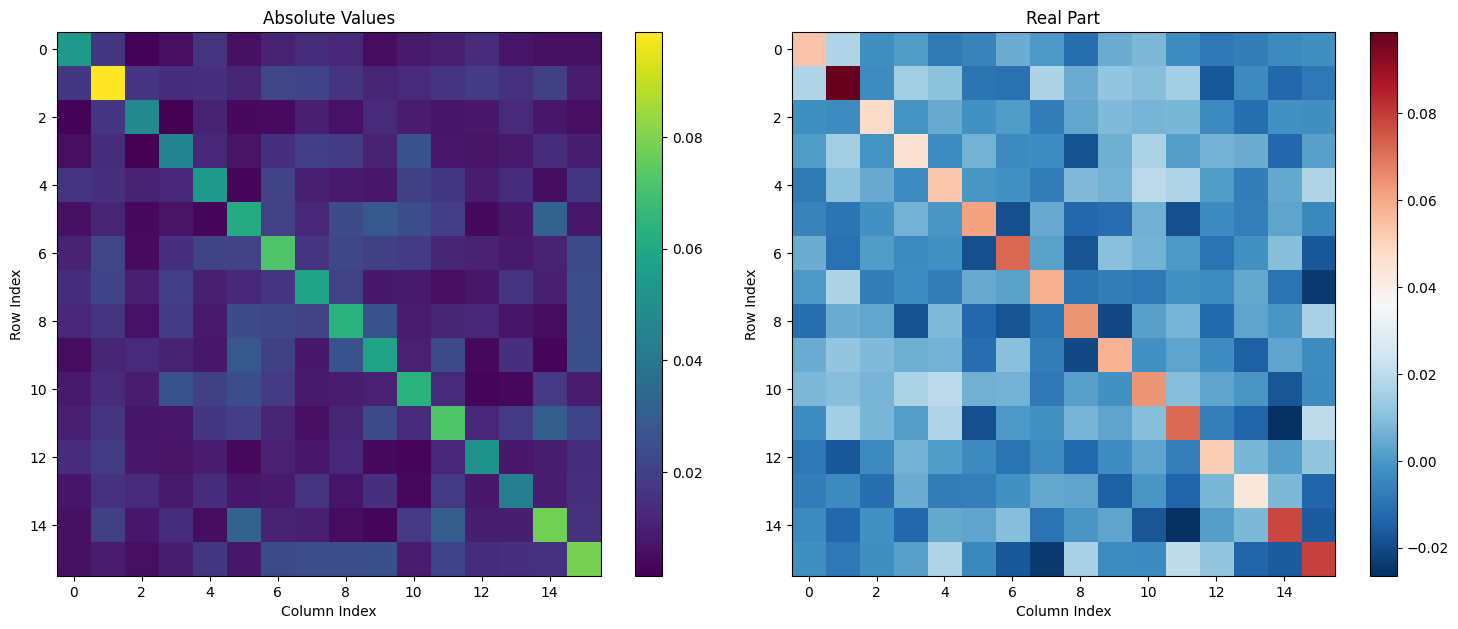

In [ ]:
# Get the density matrix as numpy array
rho_matrix = rho_ls.full()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot absolute values
im1 = ax1.imshow(np.abs(rho_matrix), cmap='viridis')
ax1.set_title('Absolute Values')
ax1.set_xlabel('Column Index')
ax1.set_ylabel('Row Index')
plt.colorbar(im1, ax=ax1)

# Plot real and imaginary parts
im2 = ax2.imshow(np.real(rho_matrix), cmap='RdBu_r')
ax2.set_title('Real Part')
ax2.set_xlabel('Column Index')
ax2.set_ylabel('Row Index')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Create another figure for imaginary part
plt.figure(figsize=(8, 6))
im3 = plt.imshow(np.imag(rho_matrix), cmap='RdBu_r')
plt.title('Imaginary Part')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.colorbar(im3)
plt.show()